In [ ]:
import sys
sys.path.insert(0, "../")

In [2]:
import normflow as nf
import matplotlib.pyplot as plt
import torch

from fab import FABModel, HamiltoneanMonteCarlo, Metropolis
from fab.train_with_prioritised_buffer import PrioritisedBufferTrainer
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.utils.prioritised_replay_buffer import PrioritisedReplayBuffer
from examples.make_flow import make_wrapped_normflowdist

/home/laurence/miniconda3/envs/fabtorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configure Training

In [3]:
loss_type = "alpha_2_div" # "forward_kl" or "alpha_2_div"

dim: int = 2
n_intermediate_distributions: int = 2
layer_nodes_per_dim = 5
batch_size: int = 32
n_iterations: int = 500
n_eval = 100
eval_batch_size = batch_size * 10
n_plots: int = 5 # number of plots shows throughout tranining
lr: float = 2e-4
transition_operator_type: str = "hmc"  # "metropolis" or "hmc"
seed: int = 0
n_flow_layers: int = 10
# torch.set_default_dtype(torch.float64) # works with 32 bit precision
torch.manual_seed(seed)

log_w_clip_frac = 0.0

In [4]:
# buffer config
n_batches_buffer_sampling = 5
maximum_buffer_length = batch_size * 100
min_buffer_length = batch_size * n_batches_buffer_sampling * 5

## Setup Double Well target distribution

In [5]:
from fab.target_distributions.many_well import ManyWellEnergy
assert dim % 2 == 0
target = ManyWellEnergy(dim, a=-0.5, b=-6)
plotting_bounds = (-3, 3)

/home/laurence/miniconda3/envs/fabtorch/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


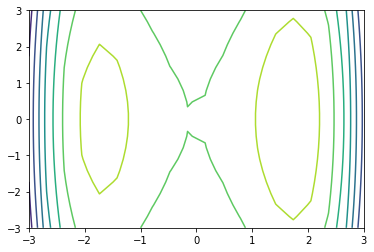

In [6]:
# plot target
plot_contours(target.log_prob, bounds=plotting_bounds)

## Setup Flow
By wrapping the [normflow library](https://github.com/VincentStimper/normalizing-flows). 

In [7]:
flow = make_wrapped_normflowdist(dim, n_flow_layers=n_flow_layers, layer_nodes_per_dim=layer_nodes_per_dim,
                                act_norm = True)

/home/laurence/miniconda3/envs/fabtorch/lib/python3.7/site-packages/normflow/flows/mixing.py:147: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1980.)
  Q = torch.qr(torch.randn(self.num_channels, self.num_channels))[0]


## Setup transition operator

In [8]:
if transition_operator_type == "hmc":
    # very lightweight HMC.
    transition_operator = HamiltoneanMonteCarlo(
        n_ais_intermediate_distributions=n_intermediate_distributions,
        n_outer=1,
        epsilon=1.0, L=2, dim=dim,
        step_tuning_method="p_accept")
elif transition_operator_type == "metropolis":
    transition_operator = Metropolis(n_transitions=n_intermediate_distributions,
                                     n_updates=5, adjust_step_size=True)
else:
    raise NotImplementedError

## Define model, trainer and plotter

In [9]:
fab_model = FABModel(flow=flow,
                     target_distribution=target,
                     n_intermediate_distributions=n_intermediate_distributions,
                     transition_operator=transition_operator,
                    loss_type=loss_type)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
scheduler = None
logger = ListLogger(save=False) # save training history

using linear spacing as there are only 2 intermediate distribution


In [10]:
def plot(fab_model, n_samples = 300):
    fig, axs = plt.subplots(1, 2)

    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0])
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1])

    # plot flow samples
    samples_flow = fab_model.flow.sample((n_samples,))
    plot_marginal_pair(samples_flow, ax=axs[0], bounds=plotting_bounds)


    # plot ais samples
    samples_ais = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples,
                                                                               logging=False)[0]
    plot_marginal_pair(samples_ais, ax=axs[1], bounds=plotting_bounds)
    axs[0].set_title("flow samples")
    axs[1].set_title("ais samples")
    plt.show()

In [11]:
# buffer
def initial_sampler():
    x, log_w = fab_model.annealed_importance_sampler.sample_and_log_weights(
            batch_size, logging=False)
    log_q_x = fab_model.flow.log_prob(x)
    return x, log_w, log_q_x
buffer = PrioritisedReplayBuffer(dim=dim, max_length=maximum_buffer_length,
                      min_sample_length=min_buffer_length,
                      initial_sampler=initial_sampler)

In [12]:
trainer = PrioritisedBufferTrainer(model=fab_model, optimizer=optimizer, logger=logger, plot=plot,
                  optim_schedular=scheduler,
                        buffer=buffer,
                        n_batches_buffer_sampling=n_batches_buffer_sampling,
                        clip_ais_weights_frac=log_w_clip_frac)

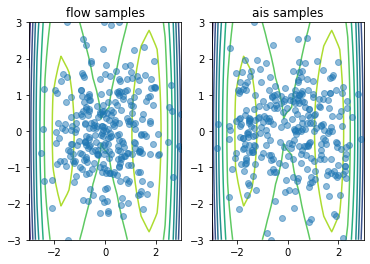

In [13]:
plot(fab_model)

# Run with visualisation

loss: 3.4730868339538574, ess base: 0.09889522939920425,ess ais: 0.13317005336284637:   0%|                                                                                                                     | 0/500 [00:00<?, ?it/s]

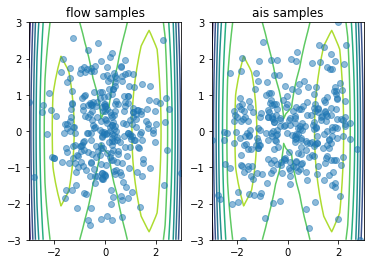

loss: 2.386892318725586, ess base: 0.5655656456947327,ess ais: 0.5116869807243347:  25%|███████████████████████████▎                                                                                  | 124/500 [00:44<01:42,  3.65it/s]

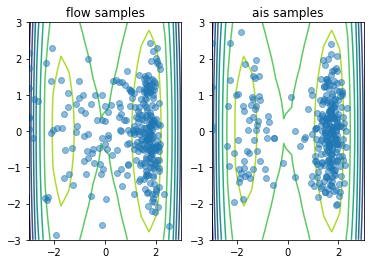

loss: 2.0991616249084473, ess base: 0.6672956347465515,ess ais: 0.7997515797615051:  50%|██████████████████████████████████████████████████████▎                                                      | 249/500 [01:30<01:29,  2.82it/s]

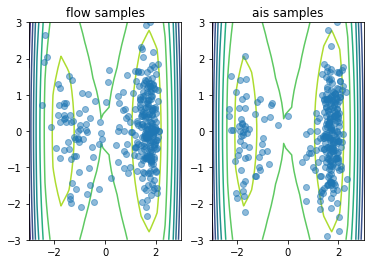

loss: 1.7948448657989502, ess base: 0.6675646305084229,ess ais: 0.7341224551200867:  75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 374/500 [02:14<00:50,  2.51it/s]

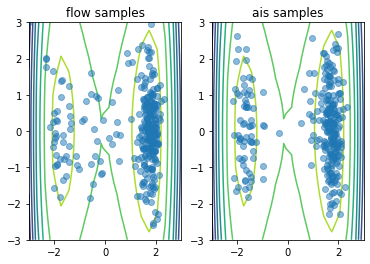

loss: 3.500462293624878, ess base: 0.5924010276794434,ess ais: 0.12585872411727905: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [02:57<00:00,  4.65it/s]

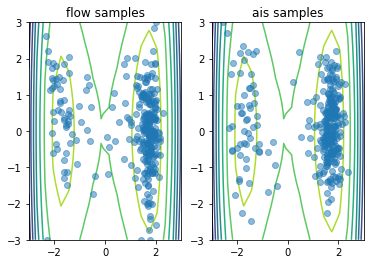

loss: 3.500462293624878, ess base: 0.5924010276794434,ess ais: 0.12585872411727905: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:58<00:00,  2.79it/s]


In [14]:
trainer.run(n_iterations=n_iterations, batch_size=batch_size, n_plot=n_plots, \
            n_eval=n_eval, eval_batch_size=eval_batch_size, save=False)

In the below plot:
ess = effective sample size
"Distance" refers to the distance moved during each intermediate transition. 

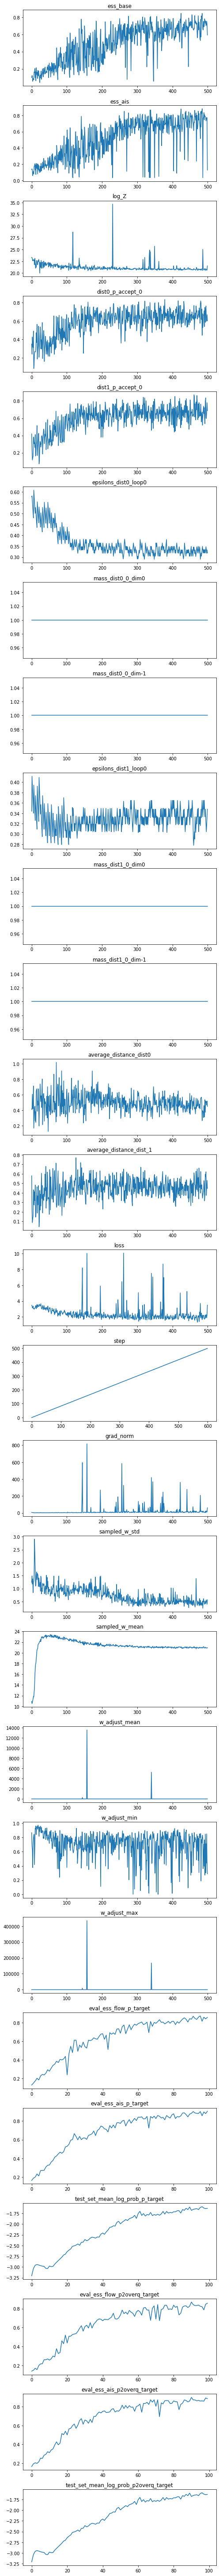

In [15]:
plot_history(logger.history)

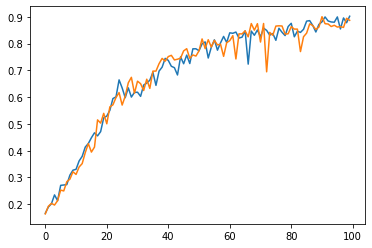

In [17]:
plt.plot(logger.history["eval_ess_ais_p_target"])
plt.plot(logger.history["eval_ess_ais_p2overq_target"])

(0.0, 10.0)

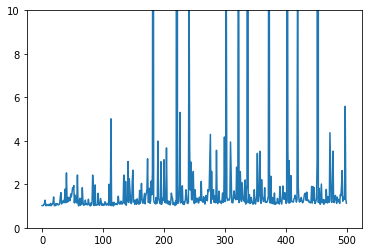

In [17]:
plt.plot(logger.history["w_adjust_max"])
plt.ylim([0, 10.0])

(0.0, 2.0)

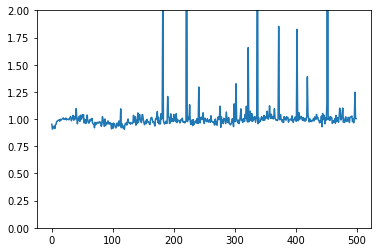

In [19]:
plt.plot(logger.history["w_adjust_mean"])
plt.ylim([0, 2.0])

## Visualise Trained Flow Model

In [ ]:
# plot samples on top of contours
n_samples = 500
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=10)
plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1], n_contour_levels=10)
# plot flow samples
samples_flow = fab_model.flow.sample((n_samples,))
plot_marginal_pair(samples_flow, ax=axs[0], bounds=plotting_bounds)
axs[0].set_title("flow samples vs target contours")
# plot ais samples
samples_ais = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples,
                                                                           logging=False)[0]
plot_marginal_pair(samples_ais, ax=axs[1], bounds=plotting_bounds)
axs[1].set_title("ais samples vs target contours")
plt.tight_layout()

## With forward kl

In [ ]:
loss_type = "forward_kl" # "forward_kl" or "alpha_2_div"

In [ ]:
# setup
flow = make_wrapped_normflowdist(dim, n_flow_layers=n_flow_layers, layer_nodes_per_dim=layer_nodes_per_dim,
                                act_norm = True)

if transition_operator_type == "hmc":
    # very lightweight HMC.
    transition_operator = HamiltoneanMonteCarlo(
        n_ais_intermediate_distributions=n_intermediate_distributions,
        n_outer=1,
        epsilon=1.0, L=2, dim=dim,
        step_tuning_method="p_accept")
elif transition_operator_type == "metropolis":
    transition_operator = Metropolis(n_transitions=n_intermediate_distributions,
                                     n_updates=5, adjust_step_size=True)
else:
    raise NotImplementedError
    

fab_model = FABModel(flow=flow,
                 target_distribution=target,
                 n_intermediate_distributions=n_intermediate_distributions,
                 transition_operator=transition_operator, loss_type=loss_type)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
scheduler = None
logger = ListLogger(save=False) # save training history


# buffer
def initial_sampler():
    x, log_w = fab_model.annealed_importance_sampler.sample_and_log_weights(
            batch_size, logging=False)
    return x, log_w
buffer = ReplayBuffer(dim=dim, max_length=maximum_buffer_length,
                      min_sample_length=min_buffer_length,
                      initial_sampler=initial_sampler)


trainer = BufferTrainer(model=fab_model, optimizer=optimizer, logger=logger, plot=plot,
                  optim_schedular=scheduler,
                        buffer=buffer,
                        n_batches_buffer_sampling=n_batches_buffer_sampling,
                        clip_ais_weights_frac=log_w_clip_frac)

In [ ]:
# run
trainer.run(n_iterations=n_iterations, batch_size=batch_size, n_plot=n_plots, \
            n_eval=n_eval, eval_batch_size=eval_batch_size, save=False)

# With Clipping

In [ ]:
log_w_clip_frac = 0.1

In [ ]:
loss_type = "alpha_2_div" # "forward_kl" or "alpha_2_div"

In [ ]:
# setup
flow = make_wrapped_normflowdist(dim, n_flow_layers=n_flow_layers, layer_nodes_per_dim=layer_nodes_per_dim,
                                act_norm = True)

if transition_operator_type == "hmc":
    # very lightweight HMC.
    transition_operator = HamiltoneanMonteCarlo(
        n_ais_intermediate_distributions=n_intermediate_distributions,
        n_outer=1,
        epsilon=1.0, L=2, dim=dim,
        step_tuning_method="p_accept")
elif transition_operator_type == "metropolis":
    transition_operator = Metropolis(n_transitions=n_intermediate_distributions,
                                     n_updates=5, adjust_step_size=True)
else:
    raise NotImplementedError
    

fab_model = FABModel(flow=flow,
                 target_distribution=target,
                 n_intermediate_distributions=n_intermediate_distributions,
                 transition_operator=transition_operator, loss_type=loss_type)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
scheduler = None
logger = ListLogger(save=False) # save training history


# buffer
def initial_sampler():
    x, log_w = fab_model.annealed_importance_sampler.sample_and_log_weights(
            batch_size, logging=False)
    return x, log_w
buffer = ReplayBuffer(dim=dim, max_length=maximum_buffer_length,
                      min_sample_length=min_buffer_length,
                      initial_sampler=initial_sampler)


trainer = BufferTrainer(model=fab_model, optimizer=optimizer, logger=logger, plot=plot,
                  optim_schedular=scheduler,
                        buffer=buffer,
                        n_batches_buffer_sampling=n_batches_buffer_sampling,
                        clip_ais_weights_frac=log_w_clip_frac)

In [ ]:
# run
trainer.run(n_iterations=n_iterations, batch_size=batch_size, n_plot=n_plots, \
            n_eval=n_eval, eval_batch_size=eval_batch_size, save=False)

In [ ]:
plot_history(logger.history)

In [ ]:
plt.plot(logger.history["loss"])
plt.show()
plt.plot(logger.history["grad_norm"])
plt.show()

In [ ]:
plt.plot(history1["loss"])
plt.show()
plt.plot(history1["grad_norm"])
plt.show()